In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 

import statsmodels

## Predict students' dropout and academic success
**Data sourced form [UCI Machine Learning Repo](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)**

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

df1_raw = X.assign(Target=y.get('Target'))

# making a copy to use 
df1 = df1_raw.copy(deep=True)

df1_raw.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
df1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

### Data Cleaning and Preprocessing

In [4]:
df1_raw.isnull().sum() # no null values

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

> ##### We removed columns related to appliction as it does not have much relation with our research project, and the meaning behind each category was left a little unclear.

In [5]:
# removing columns 
df1 = df1.drop(columns=['Application mode', 'Application order'])

> ##### The dataset is made up of binary and multiclass data represented as integers. For clarity, we referred to its documentation and converted integer values to its corresponding description (if applicable).

In [6]:
# converting binary data

binary_cols = ['Daytime/evening attendance','Displaced', 'Educational special needs', 'Debtor',
               'Tuition fees up to date', 'Scholarship holder',]

def get_attendance(val):
    if val == 1:
        return 'Day'
    else:
        return 'Evening'

def get_gender(val):
    if val == 1:
        return 'Male'
    else:
        return 'Female'

df1 = df1.assign(isDisplaced = (df1.get('Displaced') == 1))
df1 = df1.assign(hasSpecialNeeds = (df1.get('Educational special needs') == 1))
df1 = df1.assign(tuitionToDate = (df1.get('Tuition fees up to date') == 1))
df1 = df1.assign(hasScholarship = (df1.get('Scholarship holder') == 1))
df1 = df1.assign(isDebtor = (df1.get('Debtor') == 1))
df1['Gender'] = df1.get('Gender').apply(get_gender)
df1['AttendanceTime'] = df1.get('Daytime/evening attendance').apply(get_attendance)

df1 =df1.drop(columns=binary_cols)

In [27]:
# sanity check 
print(df1_raw['Displaced'].value_counts())
df1['isDisplaced'].value_counts()

1    2426
0    1998
Name: Displaced, dtype: int64


True     2426
False    1998
Name: isDisplaced, dtype: int64

In [7]:
# directly convertting integer values to its corresponding description

def get_marital_status(int):
    marital_status = {
        1:'Single',
        2:'Married',
        3:'Widower',
        4:'Divorced',
        5:'Facto Union',
        6:'Legally Separated'
    }
    return marital_status[int]

def get_course(int):
    courses = {
        33: 'Biofuel Production Technologies',
        171: 'Animation and Multimedia Design',
        8014: 'Social Service (evening attendance)',
        9003: 'Agronomy',
        9070: 'Communication Design', 
        9085: 'Veterinary Nursing', 
        9119: 'Informatics Engineering', 
        9130: 'Equinculture', 
        9147: 'Management', 
        9238: 'Social Service', 
        9254: 'Tourism', 
        9500: 'Nursing', 
        9556: 'Oral Hygiene', 
        9670: 'Advertising and Marketing Management', 
        9773: 'Journalism and Communication', 
        9853: 'Basic Education', 
        9991: 'Management (evening attendance)'
    }
    return courses[int]

def get_nationality(int):
    nationality = {
        1 : 'Portuguese',
        2 : 'German',
        6 : 'Spanish',
        11 : 'Italian',
        13 :'Dutch',
        14 : 'English',
        17 : 'Lithuanian',
        21 : 'Angolan',
        22 : 'Cape Verdean',
        24 : 'Guinean',
        25 : 'Mozambican',
        26 : 'Santomean',
        32 : 'Turkish',
        41 : 'Brazilian',
        62 : 'Romanian',
        100 : 'Moldova (Republic of)',
        101 : 'Mexican',
        103 : 'Ukrainian',
        105 : 'Russian',
        108 : 'Cuban',
        109 : 'Colombian'
    }
    return nationality[int]


df1['Marital Status'] = df1.get('Marital Status').apply(get_marital_status)
df1['Course'] = df1.get('Course').apply(get_course)
df1['Nationality'] = df1.get('Nacionality').apply(get_nationality)
df1 = df1.drop(columns=['Nacionality'])

In [29]:
# sanity check 
print(df1_raw['Marital Status'].value_counts())
df1['Marital Status'].value_counts()

1    3919
2     379
4      91
5      25
6       6
3       4
Name: Marital Status, dtype: int64


Single               3919
Married               379
Divorced               91
Facto Union            25
Legally Separated       6
Widower                 4
Name: Marital Status, dtype: int64

##### Columns associated with **education level** and contains many specific cateogories that can be arguably grouped together (some which only has one count). Below details how the data for these columns are categorized: 

> `Previous qualification`:
>
> >**Secondary** - completed high school or equivalent,
> >
> >**Higher** - bachelor's (or equivalent) or above
> >
> >**Below secondary** - did not complete high school 
>
> `Mother's qualification` and `Father's qualification`:
>
>>**Secondary** - completed high school or equivalent
>>
>>**Higher** - bachelor's (or equivalent) or above
>>
>> **Basic** - below high school education
>>
>>**Unknown** - information unknown

In [8]:
def get_prev_qual(int):
    higher_education = [2,3,4,5,6,40,42,43,39]
    
    if int == 1:
        return 'Secondary'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Below secondary'

def get_mother_qual(int):
    basic_education = [9,10,11,12,14,18,19,26,27,29,30,35,36,37,38]
    higher_education = [2,3,4,5,6,22,39,40,41,42,43,44]
    
    if int == 1:
        return 'Secondary'
    elif int in basic_education:
        return 'Basic'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Unknown'

def get_father_qual(int):
    basic_education = [9,10,11,12,13,14,18,19,20,25,26,27,29,30,31,35,36,37,38]
    higher_education = [2,3,4,5,6,22,33,39,40,31,32,43,44]
    
    if int == 1:
        return 'Secondary'
    elif int in basic_education:
        return 'Basic'
    elif int in higher_education:
        return 'Higher'
    else:
        return 'Unknown'

df1['Previous qualification'] = df1.get('Previous qualification').apply(get_prev_qual)
df1['Mother\'s qualification'] = df1.get('Mother\'s qualification').apply(get_mother_qual)
df1['Father\'s qualification'] = df1.get('Father\'s qualification').apply(get_father_qual)


##### The target variable consists of 3 categories (graduate, enrolled, droupout), but since this research is primarily concerned with whether students dropped out of school or not, we combined 'graduate' and 'erolled' into one category 

In [9]:
df1['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [10]:
# Combining 'Graduate' and 'Enrolled' into one 

def get_target(y):
    if (y == 'Graduate') or (y == 'Enrolled'):
        return 'Graduate/Enrolled'
    else:
        return 'Dropout'
        
df1['Target'] = df1.get('Target').apply(get_target)

# EDA and Visualization 

In [11]:
df1['Target'].value_counts()

Graduate/Enrolled    3003
Dropout              1421
Name: Target, dtype: int64

**Note that there is almost twice as many students who have graduated/enrolled, as expeccted.**

## Multiclass Data and Target

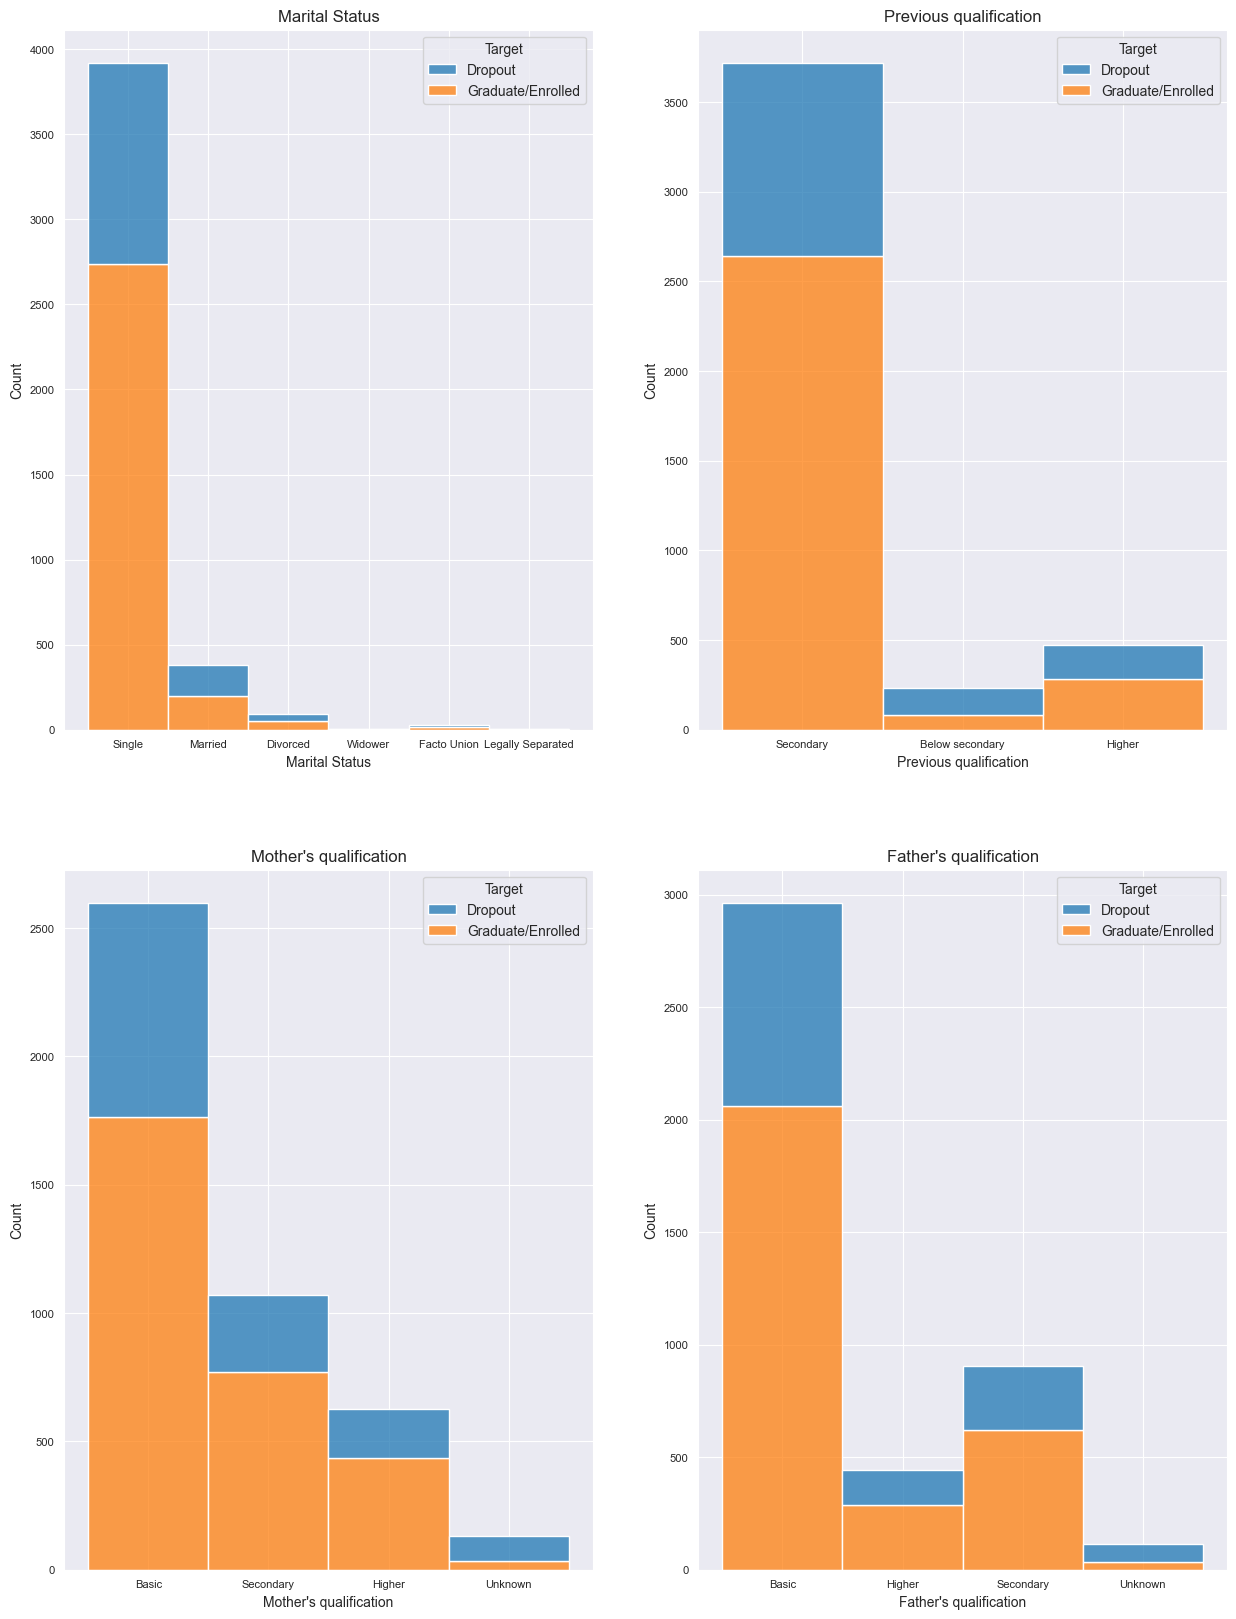

In [13]:
sns.set_style('darkgrid')

cols = ['Marital Status', 'Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']

pos = 1
plt.figure(figsize=(15,20))
for col in cols:
    plt.subplot(2,2,pos)
    b = sns.histplot(data=df1, x=col, hue='Target', multiple = 'stack')
    b.tick_params(labelsize=8)
    plt.title(f"{col}")
    pos += 1

### Marital Status and Previous Qualification Relative Frequencies

> Due to the imbalance of data, visualizing the relative frequencies of dropout and graduate/enrolled students can provide a clearer picture of potentially significant differences. 

In [60]:
# creating dataframe with relative frequencies for each target 
df1_grad = df1[df1['Target'] == 'Graduate/Enrolled']
df1_drop = df1[df1['Target'] == 'Dropout']

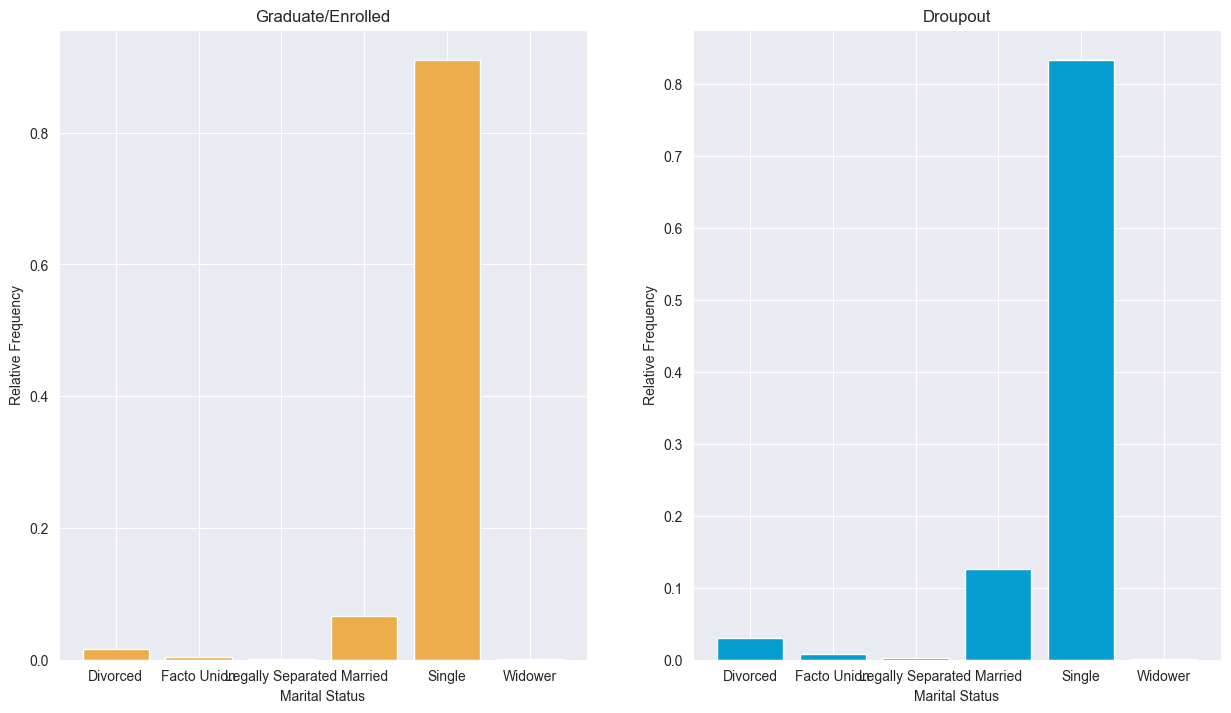

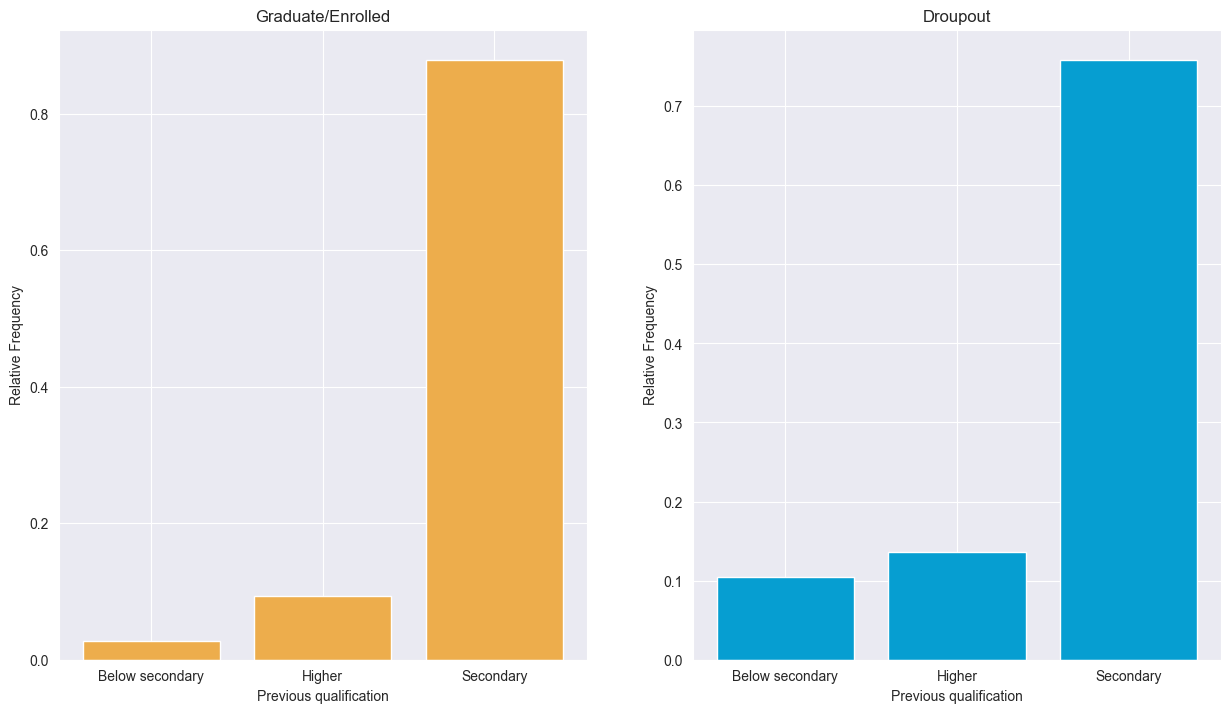

In [69]:
cols = ['Marital Status', 'Previous qualification']

pos = 1
for col in cols:
    plt.figure(figsize=(15,18))
    
    #creating DF with col, relative frequency for GRADUATE/ENROLLED
    grad_relfreq = df1_grad.groupby(col).count().reset_index()
    grad_relfreq = grad_relfreq.assign(Relative_Frequency = grad_relfreq.get('Course') / df1_grad.shape[0])
    grad_relfreq = grad_relfreq[[col, 'Relative_Frequency']]
    #convert bool val to String object
    grad_relfreq[col] = grad_relfreq.get(col).astype(str)

    #plot
    plt.subplot(2,2,pos)
    plt.bar(data=grad_relfreq, x=col, height='Relative_Frequency', color='#edad4c')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Graduate/Enrolled')

    #increment 
    pos += 1

    #creating DF with col, relative frequency for DROPOut
    drop_relfreq = df1_drop.groupby(col).count().reset_index()
    drop_relfreq = drop_relfreq.assign(Relative_Frequency = drop_relfreq.get('Course') / df1_drop.shape[0])
    drop_relfreq = drop_relfreq[[col, 'Relative_Frequency']]
    drop_relfreq[col] = drop_relfreq.get(col).astype(str)

    #plot
    plt.subplot(2,2,pos)
    plt.bar(data=drop_relfreq, x=col, height='Relative_Frequency', color='#069ed1')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Droupout')
    
    plt.show()

    #increment 
    pos += 1

> ## Key Observations

- A **larger proportion** of dropout students are **married** or **divorced**
- A **larger proportion** of dropout students did not complete high school (**_i.e., Below secondary_**)

In [78]:
# storing relative frequencies 

    #marital_status
marital_status = pd.crosstab(df1['Target'], df1['Marital Status'])
marital_status_relfreq_drop = marital_status.loc['Dropout'] / df1_drop.shape[0]
marital_status_relfreq_grad = marital_status.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #previous qualification
prev_qual = pd.crosstab(df1['Target'], df1['Previous qualification'])
prev_qual_relfreq_drop = prev_qual.loc['Dropout'] / df1_drop.shape[0]
prev_qual_relfreq_grad = prev_qual.loc['Graduate/Enrolled'] / df1_grad.shape[0]

## Binary Data and Target

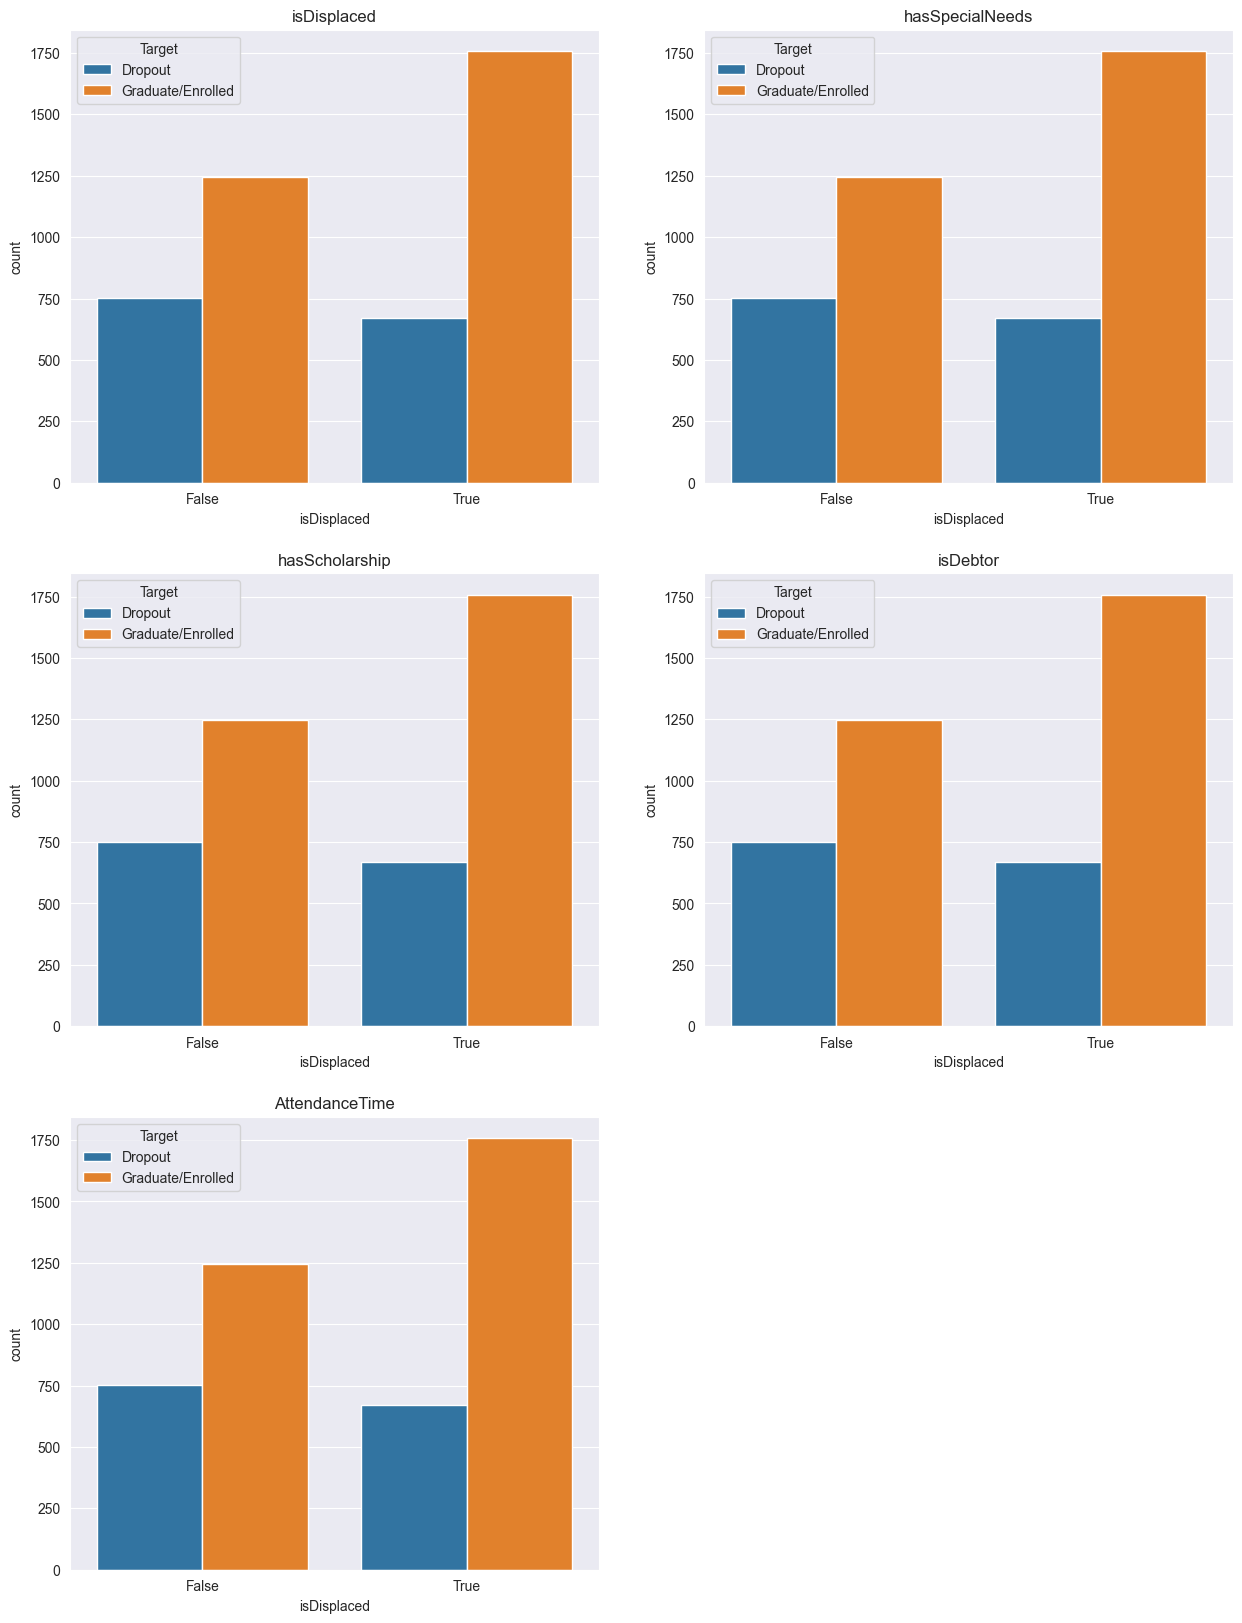

In [14]:
cols = ['isDisplaced', 'hasSpecialNeeds', 'hasScholarship', 'isDebtor', 'AttendanceTime']

pos = 1
plt.figure(figsize=(15,20))
for col in cols:
    plt.subplot(3,2,pos)
    b = sns.countplot(data=df1, x='isDisplaced', hue='Target')
    # b.tick_params(labelsize=8)
    plt.title(f"{col}")
    pos += 1

### Relative Frequencies and the Target
> Similarly, due to the imbalance of data, rather than plotting the counts of each feature, it's worth graphing the relative frequencies of each feature for each target variable. 

In [59]:
# creating dataframe with relative frequencies for each target 
df1_grad = df1[df1['Target'] == 'Graduate/Enrolled']
df1_drop = df1[df1['Target'] == 'Dropout']

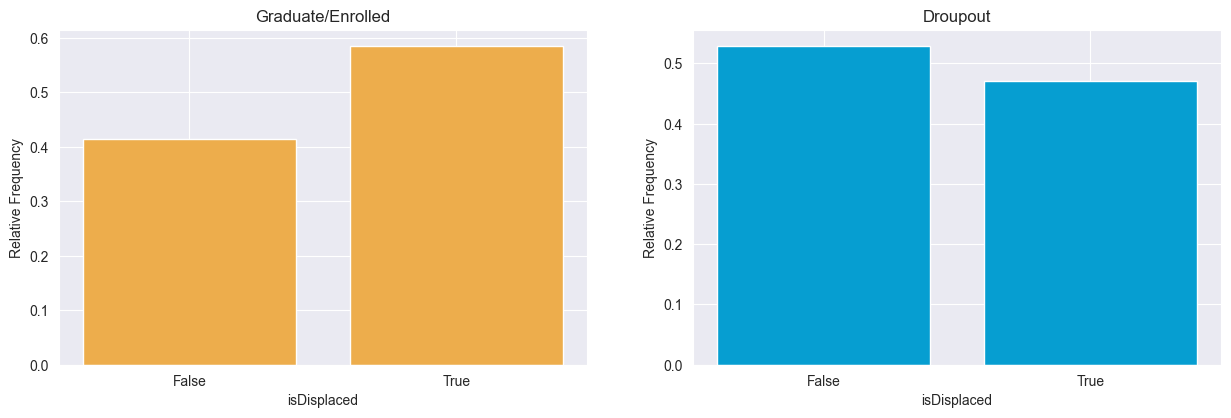

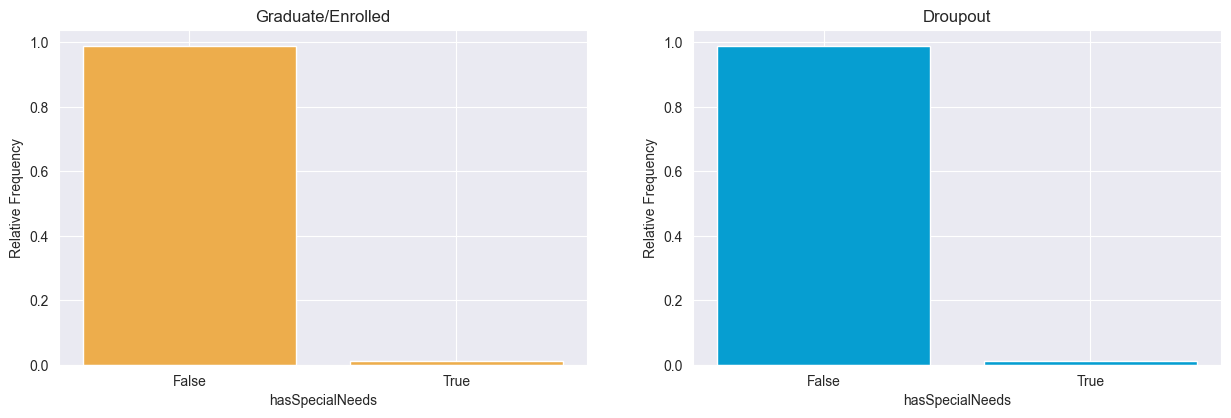

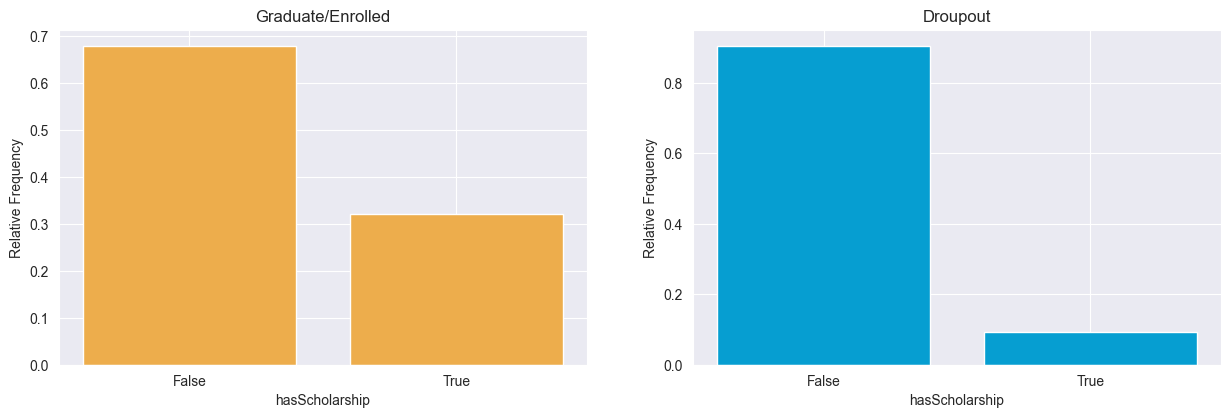

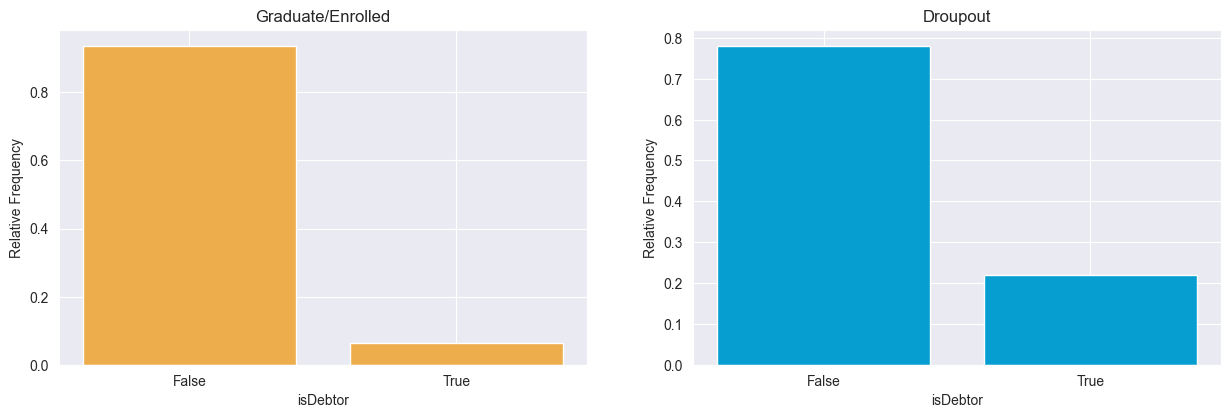

In [15]:
# features with boolean types
cols = ['isDisplaced', 'hasSpecialNeeds', 'hasScholarship', 'isDebtor']

pos = 1
for col in cols:
    plt.figure(figsize=(15,20))
    
    #creating DF with col, relative frequency for GRADUATE/ENROLLED
    grad_relfreq = df1_grad.groupby(col).count().reset_index()
    grad_relfreq = grad_relfreq.assign(Relative_Frequency = grad_relfreq.get('Course') / df1_grad.shape[0])
    grad_relfreq = grad_relfreq[[col, 'Relative_Frequency']]
    #convert bool val to String object
    grad_relfreq[col] = grad_relfreq.get(col).astype(str)

    #plot
    plt.subplot(4,2,pos)
    plt.bar(data=grad_relfreq, x=col, height='Relative_Frequency', color='#edad4c')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Graduate/Enrolled')

    #increment 
    pos += 1

    #creating DF with col, relative frequency for DROPOut
    drop_relfreq = df1_drop.groupby(col).count().reset_index()
    drop_relfreq = drop_relfreq.assign(Relative_Frequency = drop_relfreq.get('Course') / df1_drop.shape[0])
    drop_relfreq = drop_relfreq[[col, 'Relative_Frequency']]
    drop_relfreq[col] = drop_relfreq.get(col).astype(str)

    #plot
    plt.subplot(4,2,pos)
    plt.bar(data=drop_relfreq, x=col, height='Relative_Frequency', color='#069ed1')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title('Droupout')
    
    plt.show()

    #increment 
    pos += 1

> ### **Key Observations**


- A **larger proportion** of dropout students were **not displaced** compared to graduate/enrolled students.
- A **smaller proprotion** of dropout students **had a scholarship**.
- A **larger proportion** of dropout students **were debtors**. 

In [58]:
# storing relative frequencies 

    #isDisplaced
displaced = pd.crosstab(df1['Target'], df1['isDisplaced'])
displaced_relfreq_drop = displaced.loc['Dropout'] / df1_drop.shape[0]
displaced_relfreq_grad = displaced.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #hasScholarship
hasScholarship = pd.crosstab(df1['Target'], df1['hasScholarship'])
hasScholarship_relfreq_drop = hasScholarship.loc['Dropout'] / df1_drop.shape[0]
hasScholarship_relfreq_grad = hasScholarship.loc['Graduate/Enrolled'] / df1_grad.shape[0]

    #isDebtor
isDebtor = pd.crosstab(df1['Target'], df1['isDebtor'])
isDebtor_relfreq_drop = isDebtor.loc['Dropout'] / df1_drop.shape[0]
isDebtor_relfreq_grad = isDebtor.loc['Graduate/Enrolled'] / df1_grad.shape[0]

## Quantitative data: Identifying Correlations

In [16]:
df1.head()

,Marital Status,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Gender,...,Inflation rate,GDP,Target,isDisplaced,hasSpecialNeeds,tuitionToDate,hasScholarship,isDebtor,AttendanceTime,Nationality
0,Single,Animation and Multimedia Design,Secondary,122.0,Basic,Basic,5,9,127.3,Male,...,1.4,1.74,Dropout,True,False,True,False,False,Day,Portuguese
1,Single,Tourism,Secondary,160.0,Secondary,Higher,3,3,142.5,Male,...,-0.3,0.79,Graduate/Enrolled,True,False,False,False,False,Day,Portuguese
2,Single,Communication Design,Secondary,122.0,Basic,Basic,9,9,124.8,Male,...,1.4,1.74,Dropout,True,False,False,False,False,Day,Portuguese
3,Single,Journalism and Communication,Secondary,122.0,Basic,Basic,5,3,119.6,Female,...,-0.8,-3.12,Graduate/Enrolled,True,False,True,False,False,Day,Portuguese
4,Married,Social Service (evening attendance),Secondary,100.0,Basic,Basic,9,9,141.5,Female,...,-0.3,0.79,Graduate/Enrolled,False,False,True,False,False,Evening,Portuguese


In [17]:
# keep just the quantitative data for heatmap

cols = ['Admission grade', 'Age at enrollment', 'Previous qualification (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)']

df1_quant = df1[cols]
df1_quant.head()

,Admission grade,Age at enrollment,Previous qualification (grade),Unemployment rate,Inflation rate,GDP,Curricular units 2nd sem (grade),Curricular units 1st sem (grade)
0,127.3,20,122.0,10.8,1.4,1.74,0.000000,0.000000
1,142.5,19,160.0,13.9,-0.3,0.79,13.666667,14.000000
2,124.8,19,122.0,10.8,1.4,1.74,0.000000,0.000000
3,119.6,20,122.0,9.4,-0.8,-3.12,12.400000,13.428571
4,141.5,45,100.0,13.9,-0.3,0.79,13.000000,12.333333


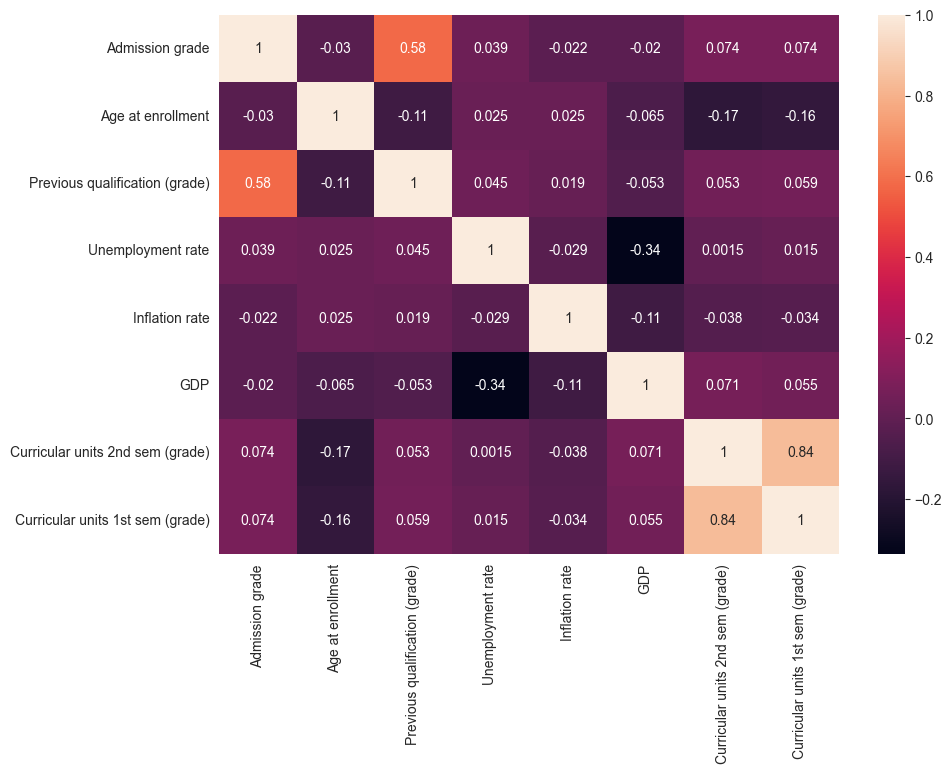

In [18]:
corr_matrix = df1_quant.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Quantiative data and the target variable

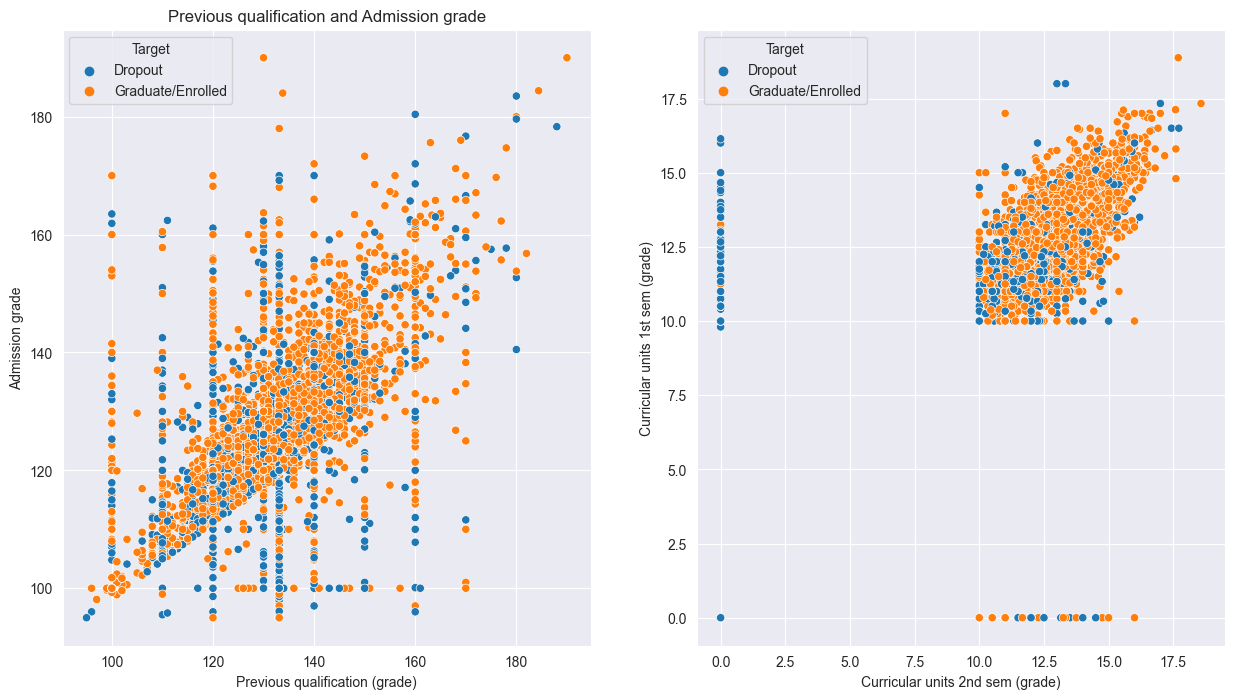

In [19]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
sns.scatterplot(data=df1, x='Previous qualification (grade)', y='Admission grade', hue='Target')
plt.title('Previous qualification and Admission grade')

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x='Curricular units 2nd sem (grade)', y='Curricular units 1st sem (grade)', hue='Target')

plt.show()

## Student Performance 
**Data sourced from [UCI Machine Learning Repo](https://archive.ics.uci.edu/dataset/320/student+performance)***

In [21]:
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 

df2_raw = X.assign(Target=y.get('Target'))
df2_raw.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Target
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,None
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,None
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,None
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,None
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,None


In [22]:
df2_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    